# DL training

## Setup

In [1]:
import numpy as np, pandas as pd
import os, random
from katlas.data import *
from katlas.train import *
from fastai.vision.all import *
from katlas.dnn import *

In [2]:
seed_everything()

In [3]:
def_device

'cuda'

## Data

In [4]:
df=pd.read_parquet('train/cddm_t5.parquet')

In [5]:
info=Data.get_kinase_info()

info = info[info.pseudo=='0']

info = info[info.kd_ID.notna()]

subfamily_map = info[['kd_ID','subfamily']].drop_duplicates().set_index('kd_ID')['subfamily']
family_map = info[['kd_ID','family']].drop_duplicates().set_index('kd_ID')['family']
group_map = info[['kd_ID','group']].drop_duplicates().set_index('kd_ID')['group']

kinase_info = pd.DataFrame(df.index.tolist(),columns=['kinase'])

kinase_info['subfamily'] = kinase_info.kinase.map(subfamily_map)
kinase_info['family'] = kinase_info.kinase.map(family_map)
kinase_info['group'] = kinase_info.kinase.map(group_map)

In [6]:
df=df.reset_index()

In [7]:
df.columns

Index(['index', '-20P', '-19P', '-18P', '-17P', '-16P', '-15P', '-14P', '-13P',
       '-12P',
       ...
       'T5_1014', 'T5_1015', 'T5_1016', 'T5_1017', 'T5_1018', 'T5_1019',
       'T5_1020', 'T5_1021', 'T5_1022', 'T5_1023'],
      dtype='object', length=1968)

In [8]:
# column name of feature and target
feat_col = df.columns[df.columns.str.startswith('T5_')]
target_col = df.columns[~df.columns.isin(feat_col)][1:]

In [9]:
feat_col

Index(['T5_0', 'T5_1', 'T5_2', 'T5_3', 'T5_4', 'T5_5', 'T5_6', 'T5_7', 'T5_8',
       'T5_9',
       ...
       'T5_1014', 'T5_1015', 'T5_1016', 'T5_1017', 'T5_1018', 'T5_1019',
       'T5_1020', 'T5_1021', 'T5_1022', 'T5_1023'],
      dtype='object', length=1024)

## Split

In [10]:
kinase_info.subfamily.value_counts()

subfamily
Eph     12
Src     11
NEK      7
STE7     7
CK1      6
        ..
GCN2     1
CDC7     1
CRK7     1
RAF      1
MAST     1
Name: count, Length: 137, dtype: int64

In [11]:
kinase_info.family.value_counts()

family
STE20    22
CAMKL    17
Eph      12
MAPK     12
Src      11
         ..
STK33     1
PDK1      1
CDC7      1
RAF       1
MAST      1
Name: count, Length: 88, dtype: int64

In [12]:
kinase_info.group.value_counts()

group
TK          80
CAMK        47
AGC         45
Other       40
CMGC        40
STE         35
TKL         21
CK1          9
Atypical     4
Name: count, dtype: int64

In [13]:
splits = get_splits(kinase_info, stratified='subfamily',nfold=5)

split0 = splits[0]

StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
# subfamily in train set: 129
# subfamily in test set: 62


/home/sky1ove/git/KATLAS/katlas/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


## Dataset

In [14]:
# dataset
ds = GeneralDataset(df,feat_col,target_col)

In [15]:
len(ds)

321

In [16]:
dl = DataLoader(ds, batch_size=64, shuffle=True)

In [17]:
xb,yb = next(iter(dl))

xb.shape,yb.shape

(torch.Size([64, 1024]), torch.Size([64, 23, 41]))

## Model

In [18]:
n_feature = len(feat_col)
n_target = len(target_col)

In [19]:

# def get_mlp(): return PSSM_model(n_feature,n_target,model='MLP')

def get_cnn(): return PSSM_model(n_feature,n_target,model='CNN')

In [20]:
model = get_cnn()

In [21]:
logits= model(xb)

In [22]:
logits.shape

torch.Size([64, 23, 41])

## Loss

In [23]:
CE(logits,yb)

tensor(3.3056, grad_fn=<MeanBackward0>)

## Metrics

In [24]:
KLD(logits,yb)

tensor(0.5323, grad_fn=<MeanBackward0>)

In [25]:
JSD(logits,yb)

tensor(0.1246, grad_fn=<MeanBackward0>)

## CV train
> cross-validation

In [26]:
oof = train_dl_cv(df,feat_col,target_col,
                  splits = splits,
                  model_func = get_cnn,
                  n_epoch=20,lr=3e-3,save='cnn_cddm')

------fold0------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.280726,3.129241,0.337730,0.086045,00:02
1,3.241528,3.118442,0.326931,0.084521,00:00
2,3.210858,3.108788,0.317277,0.081662,00:00
3,3.200399,3.069698,0.278187,0.072590,00:00
4,3.195693,2.976888,0.185377,0.049739,00:00
5,3.166100,2.936633,0.145121,0.037754,00:00
6,3.125916,2.919631,0.128121,0.033090,00:01
7,3.087971,2.914602,0.123091,0.031606,00:00
8,3.055577,2.901576,0.110064,0.028728,00:00
9,3.027860,2.899491,0.107980,0.027733,00:00


------fold1------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.282995,3.131762,0.340881,0.086980,00:00
1,3.244184,3.107079,0.316198,0.082586,00:00
2,3.212950,3.107993,0.317112,0.080378,00:00
3,3.193774,3.121538,0.330657,0.082642,00:00
4,3.167385,2.969853,0.178972,0.047170,00:00
5,3.131219,2.931188,0.140307,0.036273,00:00
6,3.097315,2.932747,0.141867,0.035560,00:00
7,3.067635,2.908916,0.118035,0.030707,00:00
8,3.042018,2.896606,0.105726,0.027578,00:00
9,3.018694,2.896546,0.105665,0.027346,00:00


------fold2------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.283071,3.125786,0.338809,0.087086,00:00
1,3.243163,3.112647,0.325670,0.084863,00:00
2,3.212751,3.106188,0.319211,0.081812,00:00
3,3.196648,3.052804,0.265827,0.069715,00:00
4,3.181442,2.967234,0.180257,0.047750,00:00
5,3.142172,2.931022,0.144045,0.037541,00:00
6,3.106615,2.921037,0.134060,0.034827,00:00
7,3.074585,2.903100,0.116123,0.030464,00:00
8,3.047058,2.895081,0.108105,0.028441,00:00
9,3.022375,2.890230,0.103253,0.027014,00:00


------fold3------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.281781,3.130100,0.338414,0.086330,00:01
1,3.241858,3.115216,0.323530,0.083923,00:00
2,3.214578,3.122394,0.330708,0.084795,00:00
3,3.200605,3.057531,0.265845,0.068597,00:00
4,3.190122,3.004941,0.213255,0.054402,00:00
5,3.148860,2.935233,0.143547,0.036774,00:00
6,3.104152,2.919654,0.127968,0.032367,00:00
7,3.067126,2.911125,0.119439,0.030059,00:00
8,3.036318,2.903696,0.112010,0.028426,00:00
9,3.011183,2.902229,0.110543,0.028073,00:00


------fold4------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.281242,3.128894,0.349759,0.089423,00:00
1,3.241549,3.110515,0.331380,0.086315,00:00
2,3.209649,3.109465,0.330330,0.084207,00:00
3,3.192693,3.038029,0.258894,0.068603,00:00
4,3.167978,2.975735,0.196599,0.052203,00:00
5,3.137975,2.930194,0.151059,0.039254,00:00
6,3.109928,2.925831,0.146696,0.037665,00:00
7,3.081912,2.908741,0.129606,0.033373,00:00
8,3.054173,2.900791,0.121655,0.031556,00:00
9,3.027997,2.893320,0.114184,0.029593,00:00


In [27]:
oof.to_parquet('raw/oof_cddm.parquet')

## Score

In [54]:
from katlas.clustering import *

from functools import partial

In [55]:
def score_df(target,pred,func):
    distance = [func(target.loc[i],pred.loc[i,target.columns]) for i in target.index]
    return pd.Series(distance,index=target.index)

In [56]:
jsd_df = partial(score_df,func=js_divergence_flat)
kld_df = partial(score_df,func=kl_divergence_flat)

In [57]:
target=df[target_col].copy()

In [58]:
kinase_info['group_split'] = oof.nfold

In [59]:
kinase_info['group_jsd'] =jsd_df(target,oof)

In [60]:
from katlas.plot import *

In [61]:
set_sns()

Text(0.5, 1.0, 'Stratified split in kinase subfamily')

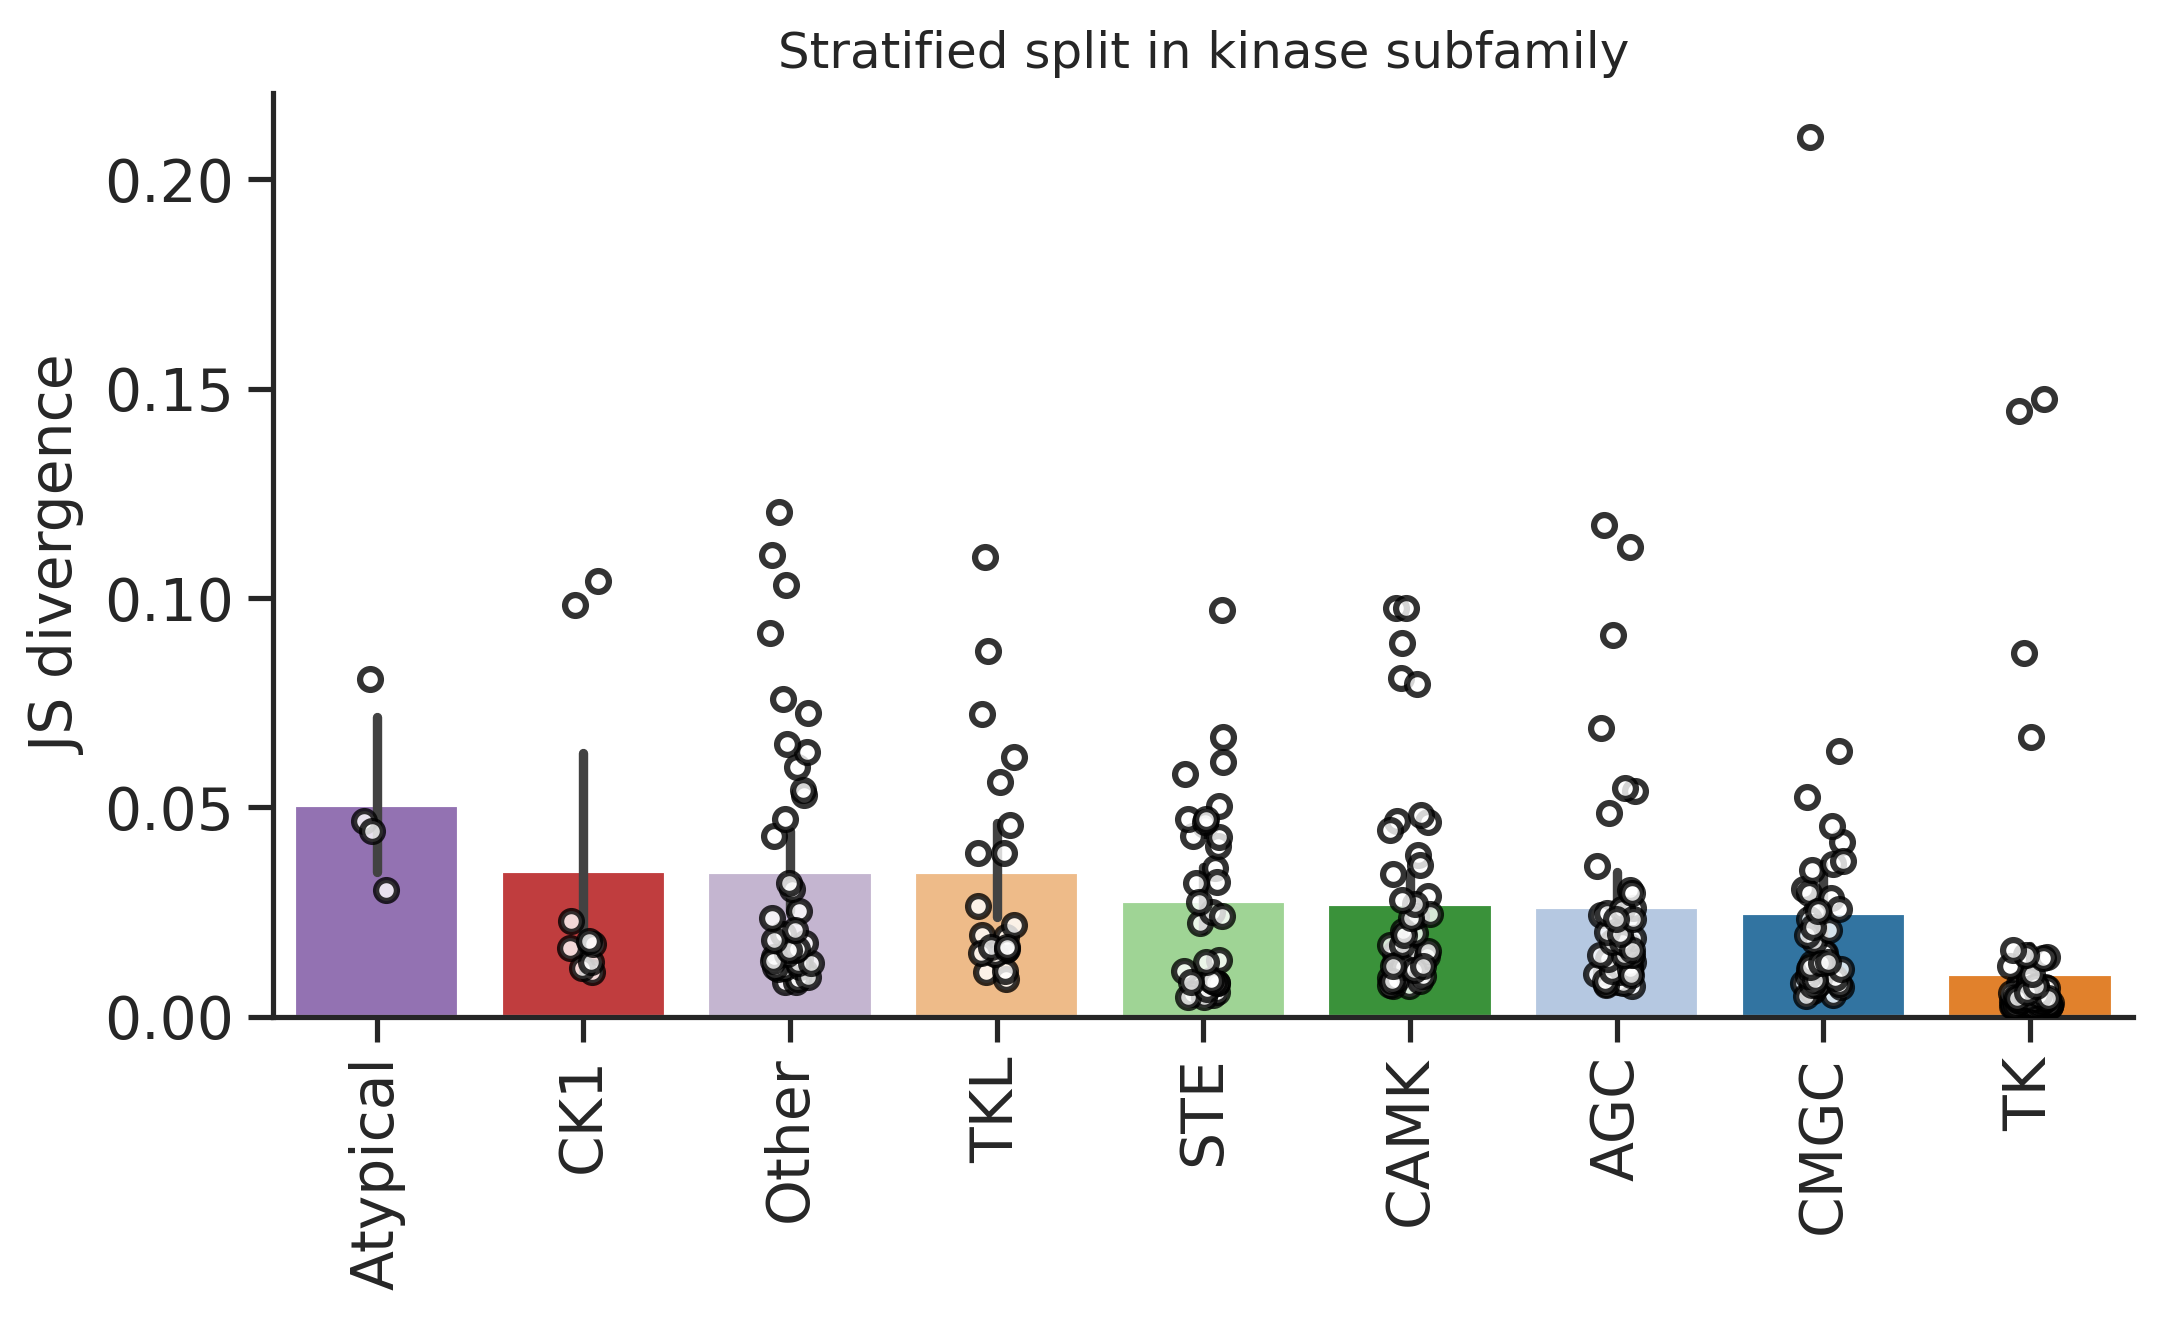

In [65]:
plot_bar(kinase_info,'group_jsd',group='group',palette=group_color,figsize=(8,4))
plt.ylabel('JS divergence')
plt.title('Stratified split in kinase subfamily')

In [37]:
group_color = pd.DataFrame(group_color).T

In [38]:
sty_color

{'S': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'T': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 'Y': (1.0, 0.4980392156862745, 0.054901960784313725)}

In [39]:
group_color = group_color.reset_index(names='modi_group')

In [40]:
info = Data.get_kinase_info()

In [41]:
subfamily_color = info[['modi_group','subfamily']].merge(group_color).drop(columns=['modi_group']).set_index('subfamily')

In [42]:
subfamily_color = subfamily_color.apply(tuple, axis=1).to_dict()

Text(0, 0.5, 'JS divergence')

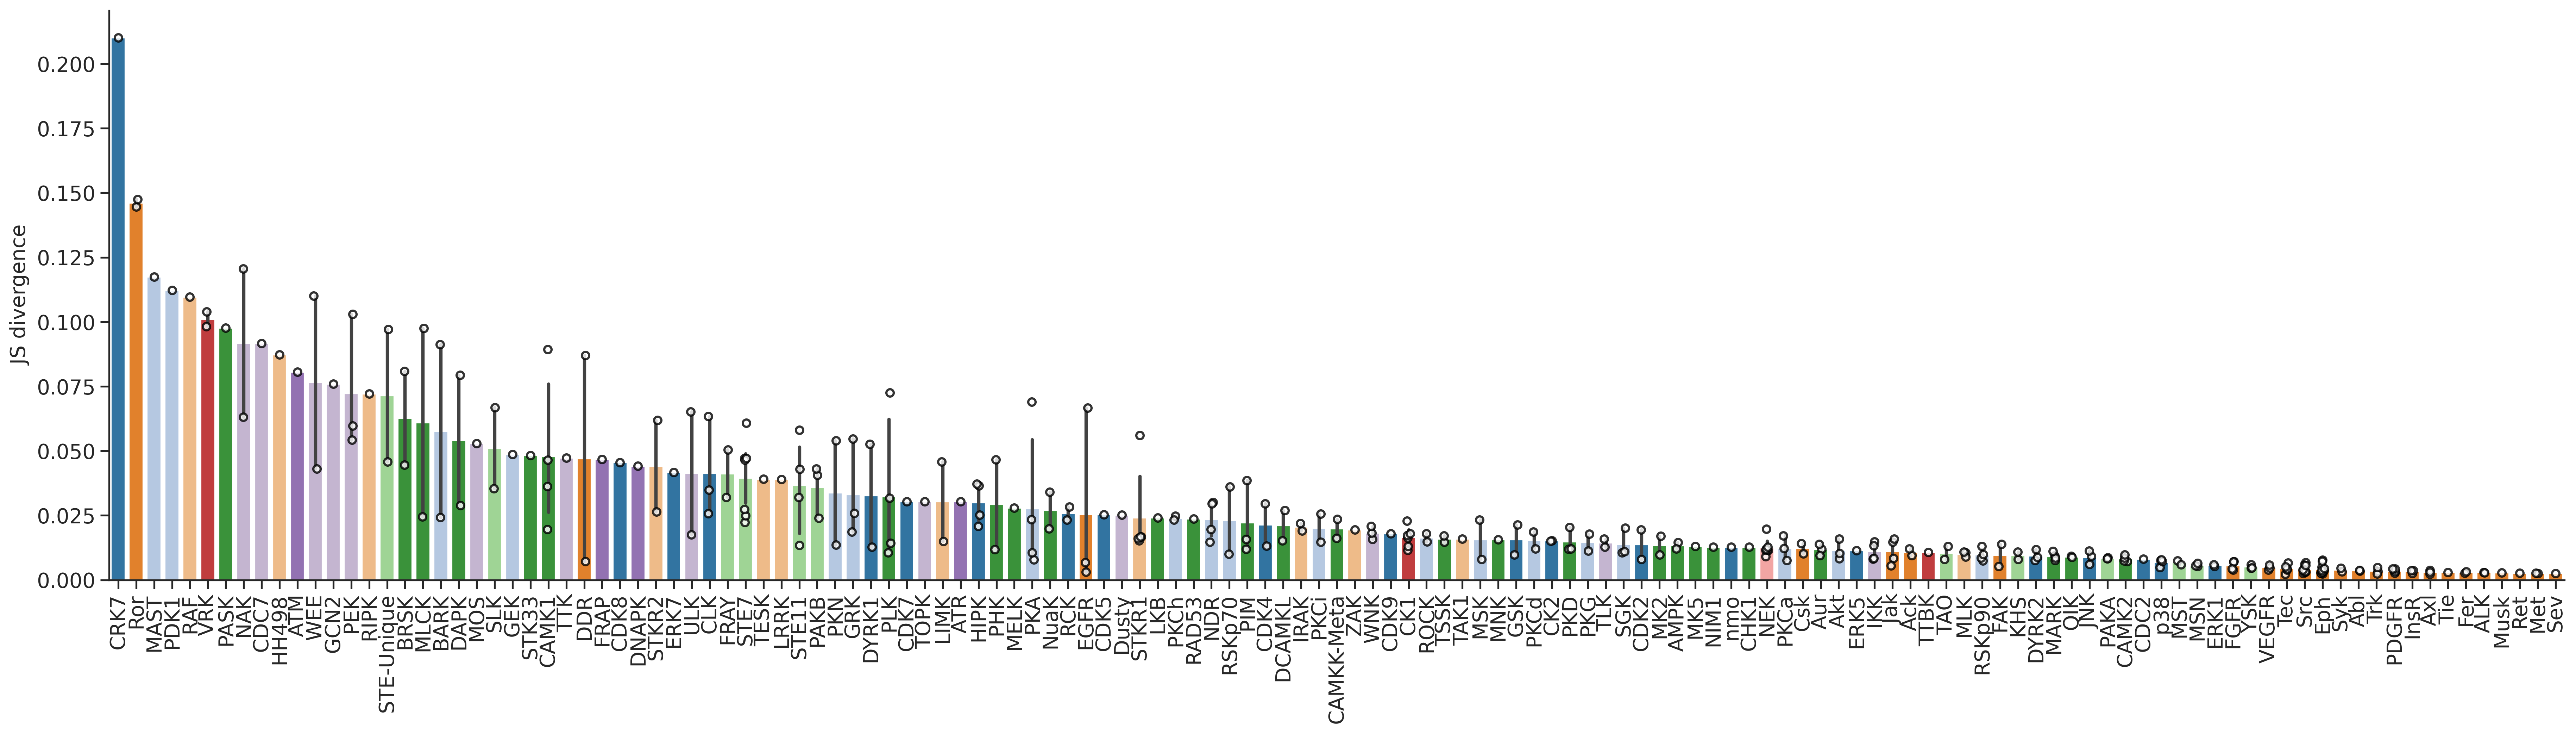

In [43]:
plot_bar(kinase_info,'group_jsd',group='subfamily',palette = subfamily_color, figsize=(30,7))
plt.ylabel('JS divergence')
# plt.title('Stratified split in kinase subfamily')

In [44]:
kinase_info.sort_values('group_jsd')

,kinase,subfamily,family,group,group_split,group_jsd
18,Q06418_TYRO3_HUMAN_KD1,Axl,Axl,TK,4,0.002317
25,P51813_BMX_HUMAN_KD1,Tec,Tec,TK,0,0.002320
1,P29320_EPHA3_HUMAN_KD1,Eph,Eph,TK,1,0.002459
17,P04629_NTRK1_HUMAN_KD1,Trk,Trk,TK,2,0.002460
15,P54753_EPHB3_HUMAN_KD1,Eph,Eph,TK,1,0.002482
...,...,...,...,...,...,...
320,Q6P0Q8_MAST2_HUMAN_KD1,MAST,MAST,AGC,0,0.117464
318,O14976_GAK_HUMAN_KD1,NAK,NAK,Other,3,0.120520
305,Q01974_ROR2_HUMAN_KD1,Ror,Ror,TK,2,0.144621
317,Q01973_ROR1_HUMAN_KD1,Ror,Ror,TK,3,0.147486


In [45]:
from katlas.pssm import *

In [46]:
def plot_one_pssm(target,pred,idx):
    target_pssm = recover_pssm(target.loc[idx])
    pred_pssm = recover_pssm(pred.loc[idx,target.columns])
    plot_heatmap(target_pssm,figsize=(10,6))
    plot_heatmap(pred_pssm,figsize=(10,6))

In [47]:
set_sns(100)

CDK12:

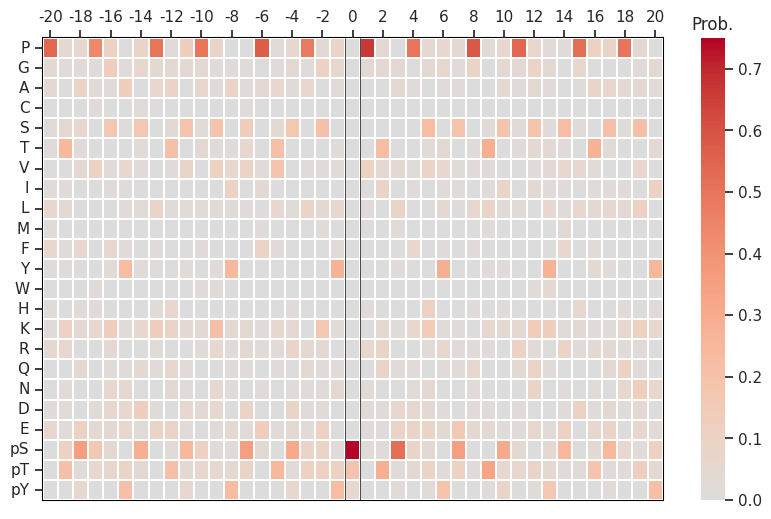

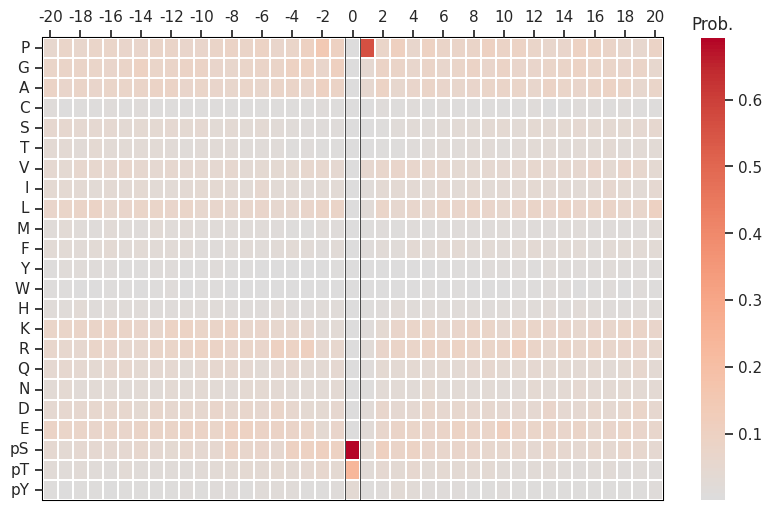

In [48]:
plot_one_pssm(target,oof,315)

Compare with pspa CDK12:

In [49]:
df2=pd.read_parquet('train/pspa_t5.parquet')

In [50]:
series= df2[df2.index.str.contains('CDK12')].iloc[0]

In [51]:
plot_heatmap

<function katlas.pssm.plot_heatmap(heatmap_df, ax=None, position_label=True, figsize=(5, 6), include_zero=True, scale_pos_neg=False, colorbar_title='Prob.')>

<Axes: >

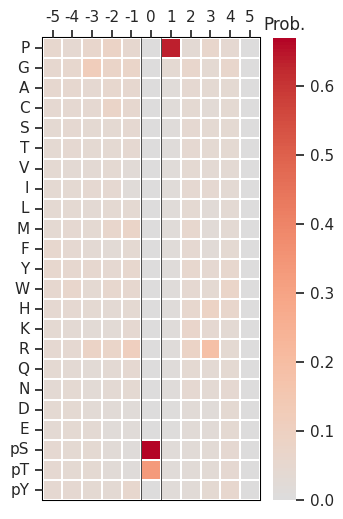

In [52]:
plot_heatmap(recover_pssm(series),figsize=(3.5,6))